# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import os
import shutil
import subprocess
import zipfile
import re
import random
from sklearn.preprocessing import MinMaxScaler
import itertools

c:\Users\Surface\anaconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global Definitions

In [3]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [4]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

window_size = 7
input_size = 1
hidden_size = 64
num_stacked_layers = 2
loss_function = nn.MSELoss()
learning_rate = 0.0001
bach_size = 16


2.5.1
None
None
False


### Utilities 

In [5]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")  # Debugging shapes
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    print(f"Shape of X_tensor: {X_tensor.shape}, Shape of y_tensor: {y_tensor.shape}")  # Debugging shapes
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_one_epoch(model, train_loader, optimizer, loss_function, epoch, teacher_forcing_prob=0.5):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass
        output = model(x_batch)

        # Apply teacher forcing
        if random.random() < teacher_forcing_prob:
            x_batch = x_batch.clone()  # Avoid in-place modification
            x_batch[:, -1, 0] = y_batch[:, 0]

        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss_across_batches = running_loss / len(train_loader)
    print(f'Average Loss: {avg_loss_across_batches:.3f}')
    return avg_loss_across_batches


def validate_one_epoch(model, val_loader):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(val_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************\n')
    return avg_loss_across_batches

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, teacher_forcing_prob=0.5):
    """
    Train the given model with validation and return training/validation metrics.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    huber_criterion = nn.HuberLoss(delta=1.0)  # Use HuberLoss
    mae_criterion = nn.L1Loss()  # MAE Loss

    train_mse_losses, val_mse_losses = [], []
    train_mae_losses, val_mae_losses = [], []

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state

    for epoch in range(epochs):
        # Training phase
        model.train(True)
        running_mse_loss = 0.0
        running_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            mse_loss = huber_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_mse_loss += mse_loss.item()
            running_mae_loss += mae_loss.item()

            optimizer.zero_grad()
            mse_loss.backward()
            optimizer.step()

        avg_train_mse = running_mse_loss / len(train_loader)
        avg_train_mae = running_mae_loss / len(train_loader)
        train_mse_losses.append(avg_train_mse)
        train_mae_losses.append(avg_train_mae)

        # Validation phase
        model.eval()
        running_mse_loss = 0.0
        running_mae_loss = 0.0

        with torch.no_grad():
            for batch_index, batch in enumerate(val_loader):
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)

                output = model(x_batch)
                mse_loss = huber_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_mse_loss += mse_loss.item()
                running_mae_loss += mae_loss.item()

        avg_val_mse = running_mse_loss / len(val_loader)
        avg_val_mae = running_mae_loss / len(val_loader)
        val_mse_losses.append(avg_val_mse)
        val_mae_losses.append(avg_val_mae)

        # Save the best model
        if avg_val_mse < best_val_loss:
            best_val_loss = avg_val_mse
            best_model_state = model.state_dict()

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch + 1}: Train MSE={avg_train_mse:.4f}, Val MSE={avg_val_mse:.4f}, Train MAE={avg_train_mae:.4f}, Val MAE={avg_val_mae:.4f}")

    # Load the best model
    model.load_state_dict(best_model_state)

    return train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses

# def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, teacher_forcing_prob=0.5):
#     """
#     Train the given model with validation and return training/validation metrics.
#     """
#     model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#     huber_criterion = nn.HuberLoss(delta=1.0)  # Use HuberLoss
#     mae_criterion = nn.L1Loss()

#     train_losses, val_losses = [], []
#     train_mae_losses, val_mae_losses = [], []

#     best_val_loss = float('inf')
#     best_model_state = model.state_dict()  # Initialize with the current model state

#     for epoch in range(epochs):
#         avg_loss_across_batches_train = train_one_epoch(model=model, train_loader=train_loader, optimizer=optimizer, loss_function=huber_criterion, epoch=epoch)
#         train_losses.append(avg_loss_across_batches_train)
#         # Validate the model after each epoch
#         avg_loss_across_batches_val = validate_one_epoch(model=model, val_loader=val_loader)
#         val_losses.append(avg_loss_across_batches_val)


    #     # Training phase
    #     model.train()
    #     total_train_huber, total_train_mae, total_train_samples = 0.0, 0.0, 0
    #     pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    #     for batch_x, batch_y in pbar:
    #         batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    #         # Forward pass
    #         preds = model(batch_x)

    #         # Teacher forcing
    #         if random.random() < teacher_forcing_prob:
    #             batch_x = batch_x.clone()
    #             batch_x[:, -1, 0] = batch_y[:, 0]

    #         # Compute loss
    #         loss = huber_criterion(preds, batch_y)

    #         # Backward pass
    #         optimizer.zero_grad()
    #         loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    #         optimizer.step()

    #         # Track training metrics
    #         batch_size = batch_x.size(0)
    #         total_train_samples += batch_size
    #         total_train_huber += huber_criterion(preds, batch_y).item() * batch_size
    #         total_train_mae += mae_criterion(preds, batch_y).item() * batch_size

    #         pbar.set_postfix(huber_loss=loss.item())

    #     avg_train_huber = total_train_huber / total_train_samples
    #     avg_train_mae = total_train_mae / total_train_samples
    #     train_huber_losses.append(avg_train_huber)
    #     train_mae_losses.append(avg_train_mae)

    #     # Validation phase
    #     model.eval()
    #     total_val_huber, total_val_mae, total_val_samples = 0.0, 0.0, 0
    #     with torch.no_grad():
    #         for batch_x, batch_y in val_loader:
    #             batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    #             preds = model(batch_x)

    #             batch_size = batch_x.size(0)
    #             total_val_samples += batch_size
    #             total_val_huber += huber_criterion(preds, batch_y).item() * batch_size
    #             total_val_mae += mae_criterion(preds, batch_y).item() * batch_size

    #     avg_val_huber = total_val_huber / total_val_samples
    #     avg_val_mae = total_val_mae / total_val_samples
    #     val_huber_losses.append(avg_val_huber)
    #     val_mae_losses.append(avg_val_mae)

    #     # Save the best model
    #     if avg_val_huber < best_val_loss:
    #         best_val_loss = avg_val_huber
    #         best_model_state = model.state_dict()

    #     # Adjust learning rate
    #     scheduler.step()

    #     print(f"Epoch {epoch+1}: Train Huber={avg_train_huber:.4f}, Val Huber={avg_val_huber:.4f}, Train MAE={avg_train_mae:.4f}, Val MAE={avg_val_mae:.4f}")

    # # Load the best model
    # model.load_state_dict(best_model_state)

    return train_losses, val_losses, train_mae_losses, val_mae_losses

def plot_metrics(train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses, predictions_rescaled, actual_values, save_path="training_summary.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Define the number of epochs
    epochs = len(train_mse_losses)
    epoch_ticks = range(1, epochs + 1)  # Epoch numbers start from 1

    # Plot MSE Loss
    plt.subplot(1, 3, 1)
    plt.plot(epoch_ticks, train_mse_losses, label="Train MSE", color="blue")
    plt.plot(epoch_ticks, val_mse_losses, label="Val MSE", color="orange")
    plt.xticks(epoch_ticks)  # Set x-axis ticks to integer epoch numbers
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Mean Squared Error (MSE) Loss")
    plt.legend()

    # # Plot MAE Loss
    # plt.subplot(1, 3, 2)
    # plt.plot(epoch_ticks, train_mae_losses, label="Train MAE", color="green")
    # plt.plot(epoch_ticks, val_mae_losses, label="Val MAE", color="red")
    # plt.xticks(epoch_ticks)  # Set x-axis ticks to integer epoch numbers
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Mean Absolute Error (MAE) Loss")
    # plt.legend()

    # Plot Actual vs Predicted Values
    plt.subplot(1, 3, 3)
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   


def recursive_forecast(model, init_window, steps=200):
    """
    Perform recursive forecasting using the trained model.

    Args:
        model: The trained Transformer model.
        init_window: The initial sequence window (tensor).
        steps: Number of forecasting steps.
        std: Standard deviation used for normalization.
        mean: Mean used for normalization.

    Returns:
        np.array: Forecasted values rescaled to the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            # Append the prediction
            preds.append(pred_value)

            next_value = torch.tensor([[pred_value]], dtype=torch.float32,  device=device)  # Convert to tensor for concatenation

            # Update the sequence by appending the prediction and removing the oldest value
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)  # Update the sequence
            # # Optional: Clamp predictions to avoid divergence
            # current_seq = torch.clamp(current_seq, min=-3, max=3)  # Adjust range based on normalized data

    print(f"first 10 predictions: {preds[:10]}")
    preds = np.array(preds) 
    return preds

### Long short-term memory (LSTM) RNN Model

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Load and Split the dataset into train-validation

In [7]:
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

window_size = 7
bach_size = 32
data_path = "./Data/Xtrain.mat"
# Load and normalize
train_dataset = loadmat(data_path)
Xtrain = train_dataset['Xtrain']
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain_normalized = scaler.fit_transform(Xtrain)

# Split before augmentation
size_of_test = 200 + window_size
Xtrain_real = Xtrain_normalized[:-size_of_test]
Xval_real = Xtrain_normalized[-size_of_test:]

# Define augmentation functions
def add_noise(x, std=0.01):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.2):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Augment training data
augmented = [Xtrain_real]  # 1x original

for _ in range(3):  # 3x noise
    augmented.append(add_noise(Xtrain_real))

for _ in range(3):  # 3x drift
    augmented.append(add_drift(Xtrain_real))

for _ in range(3):  # 3x time warp
    augmented.append(time_warp(Xtrain_real))

Xtrain_augmented = np.vstack(augmented)
print("Augmented shape:", Xtrain_augmented.shape)

# Create sequences
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

X_all, y_all = create_sequences(Xtrain_augmented, window_size)
X_val, y_val = create_sequences(Xval_real, window_size)

# Convert to PyTorch loaders
X_train_tensor = torch.tensor(X_all, dtype=torch.float32)
y_train_tensor = torch.tensor(y_all, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=bach_size, shuffle=True)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=bach_size)

# Final check
print(f"Training sequences: {X_all.shape[0]}")
print(f"Validation sequences: {X_val.shape[0]}")

Augmented shape: (7930, 1)
Training sequences: 7923
Validation sequences: 200


### Training the Model 

In [ ]:
# Define the hyperparameter grid
param_grid = {
    "learning_rate": [0.0001, 0.001, 0.01],
    "batch_size": [16, 32],
    "hidden_size": [32, 64, 128],
    "num_stacked_layers": [1, 2],
    "window_size": [5, 7, 10]
}

# Create a DataFrame to store results
results = pd.DataFrame(columns=["learning_rate", "batch_size", "hidden_size", "num_stacked_layers", "window_size", "train_mse", "val_mse", "train_mae", "val_mae"])

# Initialize variables to track the best model
best_model = None
best_params = None
best_val_mse = float("inf")

# Iterate over all combinations of hyperparameters
for params in itertools.product(*param_grid.values()):
    # Unpack the parameters
    learning_rate, batch_size, hidden_size, num_stacked_layers, window_size = params

    print(f"Training with params: LR={learning_rate}, Batch Size={batch_size}, Hidden Size={hidden_size}, Layers={num_stacked_layers}, Window Size={window_size}")

    # Update global variables
    bach_size = batch_size  # Update batch size globally
    window_size = window_size  # Update window size globally

    # Recreate the dataset with the new window size
    X_all, y_all = create_sequences(Xtrain_normalize, window_size)
    size_of_test = 200 + window_size
    X_train, X_val, y_train, y_val = X_all[:-size_of_test], X_all[-size_of_test:], y_all[:-size_of_test], y_all[-size_of_test:]
    train_loader, _, _ = prepare_dataloader(X_train, window_size, batch_size=batch_size)
    val_loader, _, _ = prepare_dataloader(X_val, window_size, batch_size=batch_size)

    # Initialize the model
    model = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)

    # Train the model
    train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses = train_model(
        model, train_loader, val_loader, epochs=20, lr=learning_rate
    )

    # Get the final metrics
    final_train_mse = train_mse_losses[-1]
    final_val_mse = val_mse_losses[-1]
    final_train_mae = train_mae_losses[-1]
    final_val_mae = val_mae_losses[-1]

    # Save the results
    new_row = pd.DataFrame([{
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "hidden_size": hidden_size,
        "num_stacked_layers": num_stacked_layers,
        "window_size": window_size,
        "train_mse": final_train_mse,
        "val_mse": final_val_mse,
        "train_mae": final_train_mae,
        "val_mae": final_val_mae
    }])

    results = pd.concat([results, new_row], ignore_index=True)

    # Save the best model
    if final_val_mse < best_val_mse:
        best_val_mse = final_val_mse
        best_model = model
        best_params = {
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "hidden_size": hidden_size,
            "num_stacked_layers": num_stacked_layers,
            "window_size": window_size
        }
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model saved with params: {best_params}")

# Save the results to a CSV file
results.to_csv("hyperparameter_tuning_results.csv", index=False)
print("Results saved to hyperparameter_tuning_results.csv")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(results["val_mse"], label="Validation MSE", marker="o")
plt.plot(results["val_mae"], label="Validation MAE", marker="x")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Loss")
plt.title("Hyperparameter Tuning Results")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("hyperparameter_tuning_plot.png", dpi=300)
plt.show()

print(f"Best Model Parameters: {best_params}")

In [8]:
# Initialize the Transformer model
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)

# Train the model
train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses = train_model(
    model, train_loader, val_loader, epochs=20, lr=1e-4
)

Epoch 1: Train MSE=0.1134, Val MSE=0.0679, Train MAE=0.3963, Val MAE=0.3045
Epoch 2: Train MSE=0.0686, Val MSE=0.0625, Train MAE=0.2943, Val MAE=0.3047
Epoch 3: Train MSE=0.0577, Val MSE=0.0506, Train MAE=0.2670, Val MAE=0.2638
Epoch 4: Train MSE=0.0390, Val MSE=0.0232, Train MAE=0.2033, Val MAE=0.1716
Epoch 5: Train MSE=0.0314, Val MSE=0.0179, Train MAE=0.1722, Val MAE=0.1399
Epoch 6: Train MSE=0.0305, Val MSE=0.0174, Train MAE=0.1689, Val MAE=0.1373
Epoch 7: Train MSE=0.0300, Val MSE=0.0168, Train MAE=0.1667, Val MAE=0.1354
Epoch 8: Train MSE=0.0296, Val MSE=0.0164, Train MAE=0.1651, Val MAE=0.1357
Epoch 9: Train MSE=0.0294, Val MSE=0.0163, Train MAE=0.1646, Val MAE=0.1347
Epoch 10: Train MSE=0.0293, Val MSE=0.0164, Train MAE=0.1642, Val MAE=0.1332
Epoch 11: Train MSE=0.0293, Val MSE=0.0164, Train MAE=0.1639, Val MAE=0.1332
Epoch 12: Train MSE=0.0292, Val MSE=0.0163, Train MAE=0.1639, Val MAE=0.1336
Epoch 13: Train MSE=0.0292, Val MSE=0.0161, Train MAE=0.1638, Val MAE=0.1338
Epoch 14

first 10 predictions: [-0.5589452981948853, -0.720966100692749, -0.7419016361236572, -0.6714514493942261, -0.5140438079833984, -0.297371506690979, -0.23266154527664185, -0.37233781814575195, -0.585078239440918, -0.7088402509689331]


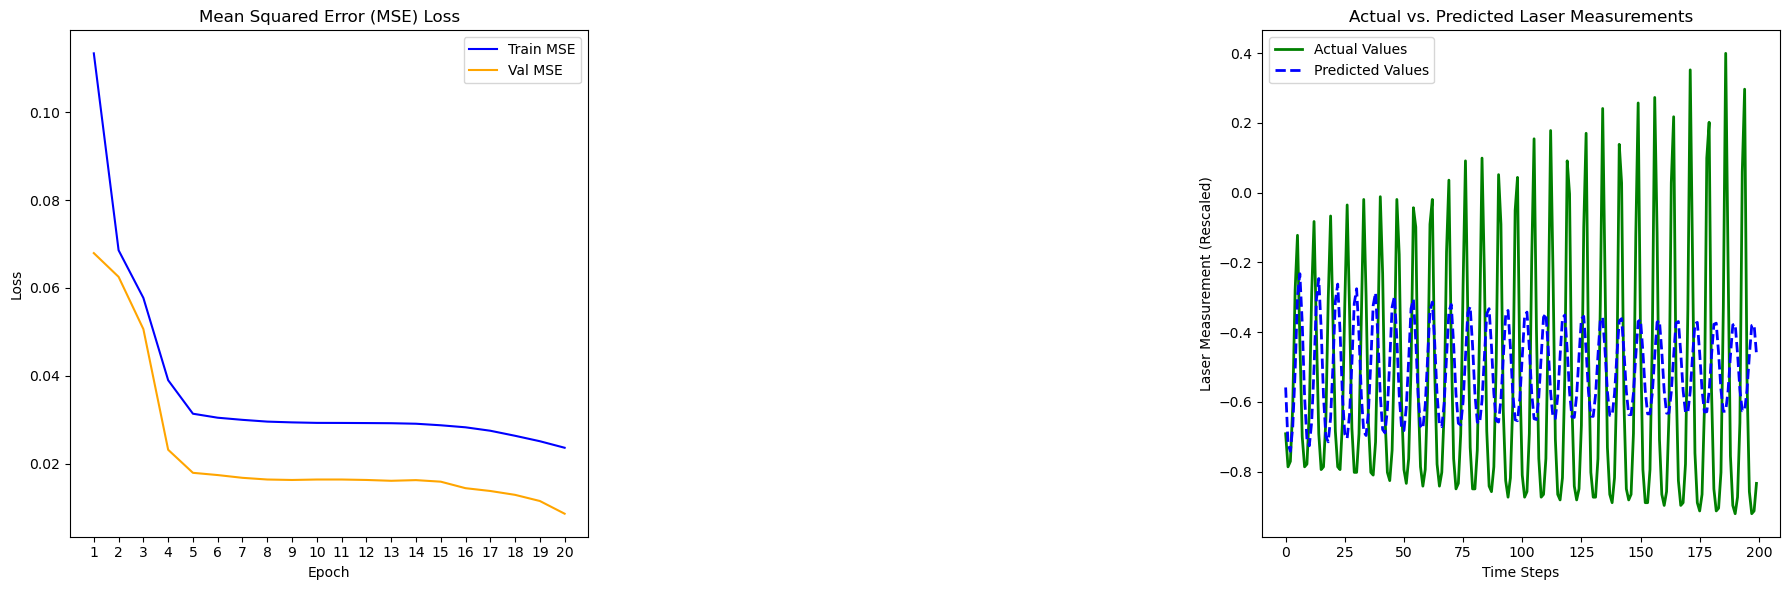

Metrics plot saved to training_summary.png


In [9]:
# Perform recursive forecasting to generate predictions
init_window = torch.tensor(X_val[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predictions = recursive_forecast(model, init_window, steps=200)

# Rescale predictions and actual values for comparison
actual_values = y_val[:len(predictions)] # Rescale to the original range

# Plot training and validation metrics
plot_metrics(train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses, predictions, actual_values)

### Save the trained model

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "time_series_transformer.pth")
print("Model saved as time_series_transformer.pth")

### Load the trained model

In [ ]:
# Load
model = TimeSeriesTransformer(model_dim=model_dim, num_heads=num_heads, num_layers=num_layers)
model.load_state_dict(torch.load("time_series_transformer.pth"))
model.to(device)

### Predict the next 200 data points recursively

In [ ]:
# Recursive forecasting for 200 steps
init_window = torch.tensor(X_val[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predictions = recursive_forecast(model, init_window, steps=200, std=std, mean=mean)

# Debugging: Print raw predictions
print(f"Raw predictions (first 10): {predictions[:10]}")

# Correctly rescale predictions back to the original range
predictions_rescaled = np.array(predictions) * std + mean

# Correctly rescale actual values for comparison
actual_values = y_val[:len(predictions_rescaled)] * std + mean  # Rescale to the original range

# Debugging: Print the ranges of predictions and actual values
print(f"max prediction: {np.max(predictions_rescaled)}, min prediction: {np.min(predictions_rescaled)}")
print(f"max actual: {np.max(actual_values)}, min actual: {np.min(actual_values)}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Laser Measurement (Rescaled)", fontsize=14)
plt.title("Actual vs. Predicted Laser Measurements", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("actual_vs_predicted_plot.png", dpi=300)  # Save the plot as a high-resolution image
plt.show()